In [138]:
# wrf area average

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime

# c1
site_latitude  = 36.6050
site_longitude = -97.485

lasso_hres = 16
wrf_hres = 3

target_height_agl = 80

# number of wrf cells in 1 lasso cell, in 1 direction 
# wrf cell span includes the cell of target location
wrf_cell_span = np.floor(lasso_hres/wrf_hres)

# convert an even number to an odd number, round down
# so the total wrf cell span is certainly smaller than a lasso cell
if (wrf_cell_span % 2) == 0:
    wrf_cell_span -= 1

# wrf cell to account for in each direction
wrf_ij_diff = (wrf_cell_span-1)/2

In [162]:
def get_wrf_area_avg_tend(dpath):

    wrf_columns = ['t_tend', 'u_tend', 'v_tend']

    df = pd.DataFrame(columns=wrf_columns)

    for file in glob.glob(dpath+'mmc_d02*')[:2]:
#     for file in glob.glob(dpath+'wrfout_d02*')[:2]:

        wrf_single = Dataset(file,'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
        area_start = site_loc_ij.values-wrf_ij_diff
        area_end = site_loc_ij.values+wrf_ij_diff

        wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
        z_agl  = wrf.getvar(wrf_single, 'height_agl')
        
#         t_tend_adv = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
#         mut = wrf.getvar(wrf_single, 'MUT', timeidx=wrf.ALL_TIMES)

#         ru_tend = wrf.getvar(wrf_single, 'RU_TEND', timeidx=wrf.ALL_TIMES)
#         muu = wrf.getvar(wrf_single, 'MUU', timeidx=wrf.ALL_TIMES)
        
        rv_tend = wrf.getvar(wrf_single, 'RV_TEND', timeidx=wrf.ALL_TIMES)
        muv = wrf.getvar(wrf_single, 'MUV', timeidx=wrf.ALL_TIMES)

        t_tend = t_tend_adv/mut
#         u_tend = ru_tend/muu
#         v_tend = rv_tend/muv

        levels = np.asarray([target_height_agl])

        df_1file = pd.DataFrame(index=wrf_time, columns=wrf_columns)

        for t_ind, t in enumerate(wrf_time): 

            t_tend_list = []

            for i in range(int(area_start[0]), int(area_end[0]+1)):
                for j in range(int(area_start[1]), int(area_end[1]+1)): 

                    
                    if wrf_time.shape[0] > 1: 
                        t_tend_1pt = t_tend[t_ind, :, i, j]
#                         u_tend_1pt = u_tend[t_ind, :, i, j]
#                         v_tend_1pt = v_tend[t_ind, :, i, j]
                    else: 
                        t_tend_1pt = t_tend[:, i, j]
#                         u_tend_1pt = u_tend[:, i, j]
#                         v_tend_1pt = v_tend[:, i, j]
                    
                    z_agl_1pt = z_agl[:, i, j]

                    # tried wrf.vinterp(), can't get it working
                    t_tend_itp = wrf.interp1d(t_tend_1pt, z_agl_1pt, levels)
#                     u_tend_itp = wrf.interp1d(u_tend_1pt, z_agl_1pt, levels)
#                     v_tend_itp = wrf.interp1d(v_tend_1pt, z_agl_1pt, levels)

                    t_tend_list.append(t_tend_itp.values[0])
#                     u_tend_list.append(u_tend_itp.values[0])
#                     v_tend_list.append(v_tend_itp.values[0])

            df_1file.loc[t, ['t_tend']] = np.mean(t_tend_list)
#             df_1file.loc[t, ['u_tend']] = np.mean(u_tend_list)
#             df_1file.loc[t, ['v_tend']] = np.mean(v_tend_list)

        df = df.append(df_1file)

    df.sort_index(inplace=True)
    
    return df

def get_lasso_df_1height(file, year, month, date):

    ds = xr.open_dataset(file)

    for ind, val in enumerate(ds['Times']): 

        ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
        ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
    #     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

    ds = ds.assign_coords({'Time': ds.Times})

    select = ds.sel(Time=slice(datetime.datetime(year, month, date), datetime.datetime(year, month, date+1)))

    subset = select.where(select.Z_LS == target_height_agl, drop=True)
    
    return subset

In [158]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/'
wrf_df = get_wrf_area_avg_tend(dpath)
wrf_df

ValueError: 'RU_TEND' is not a valid variable name

In [163]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'
wrf_df = get_wrf_area_avg_tend(dpath)
# wrf_df

KeyError: 'XLAT_V'

In [140]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

lasso_df = get_lasso_df_1height(lasso_file, 2018, 8, 5)

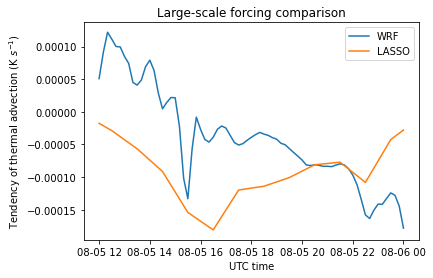

In [143]:
plt.plot(wrf_df, label='WRF')
plt.plot(lasso_df['Time'], lasso_df['TH_ADV'], label='LASSO')

plt.title('Large-scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

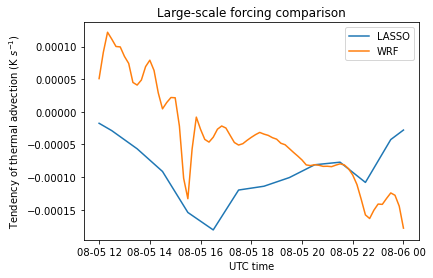

In [135]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

ds = xr.open_dataset(lasso_file)

for ind, val in enumerate(ds['Times']): 

    ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
    ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
#     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

ds0805 = ds.assign_coords({'Time': ds.Times})

sel0805 = ds0805.sel(Time=slice(datetime.datetime(2018, 8, 5), datetime.datetime(2018, 8, 6)))

sub = sel0805.where(sel0805.Z_LS == 80, drop=True)

plt.plot(sel0805['Time'], sub['TH_ADV'], label='LASSO')
plt.plot(wrf_df, label='WRF')

plt.title('Large-scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

In [128]:
sel0805['Z_LS'][0, :]

<xarray.DataArray 'Z_LS' (force_layers: 751)>
array([    0.,    20.,    40., ..., 14960., 14980., 15000.], dtype=float32)
Coordinates:
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: force_layers
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  height of forcing
    units:        m
    stagger:

In [133]:
sel0805.where(sel0805.Z_LS == 80, drop=True)['TH_ADV'][0, :]

<xarray.DataArray 'TH_ADV' (force_layers: 751)>
array([           nan,            nan,            nan,            nan,
       -1.7503646e-05,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
...
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan], dtype=float32)
Coordinates:
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: force_layers
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  tendency of thermal adv
    units:        K s-1
    stagger:

In [71]:
df = pd.DataFrame(index=wrf_time, columns=['t_tend'])

In [75]:
df.loc['2018-08-05 12:00:00']

t_tend    NaN
Name: 2018-08-05 12:00:00, dtype: object

In [67]:
t_tend_adv = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
t_tend_adv.shape

(6, 87, 220, 220)

In [53]:
time = wrf.getvar(wrf_single, 'XTIME')

In [68]:
wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

array(['2018-08-05T12:00:00.000000000', '2018-08-05T12:10:00.000000000',
       '2018-08-05T12:20:00.000000000', '2018-08-05T12:30:00.000000000',
       '2018-08-05T12:40:00.000000000', '2018-08-05T12:50:00.000000000'],
      dtype='datetime64[ns]')

In [54]:
time

<xarray.DataArray 'XTIME' ()>
array(1440.)
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 0000-00-00 **:00:00
    units:        minutes since 0000-00-00 **:00:00
    stagger:

In [51]:
import glob

glob.glob(dpath+'mmc_d02*')

['/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-06_00:00:00',
 '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/

In [50]:
np.mean(t_tend_list)

5.0943145e-05

In [5]:
interp_vals

<xarray.DataArray 'None_z' (z: 1)>
array([-0.00109099], dtype=float32)
Coordinates:
  * z        (z) float64 80.0
Attributes:
    _FillValue:     None
    missing_value:  None

In [17]:
site_loc_ij.values

array([121, 124])

In [12]:
(site_loc_ij.values-2)[0]

119

In [40]:
for i, j in zip(range(int(area_start[0]), int(area_end[0]+1)), range(int(area_start[1]), int(area_end[1]+1))): 
    print(i, j)

119 122
120 123
121 124
122 125
123 126


In [33]:
int(area_end[0]+1)

124

In [34]:
int(area_start[0])

119

In [36]:
range(int(area_start[0]), int(area_end[0]+1))

range(119, 124)

In [1]:
# read in wrf auxout & lasso files
# compare large scale forcing

# based on 
# https://github.com/a2e-mmc/assessment/blob/
# study/coupling_comparison/studies/coupling_comparison/
# preprocessing/internal/wrf_to_sowfa.ipynb

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import sys
import datetime

from mmctools.dataloaders import read_dir
from mmctools.wrf.utils import extract_column_from_wrfdata
from mmctools.coupling.sowfa import InternalCoupling
from mmctools.helper_functions import calc_wind
from mmctools.plotting import plot_timehistory_at_height, plot_profile

wrf_file_prefix  = 'mmc_d02_*'

# c1
site_latitude  = 36.6050
site_longitude = -97.485

# Define how WRF data is filtered to site specific data
# - 'interpolate': interpolate to site coordinates
# - 'nearest': use nearest WRF grid point
# - 'average': average of an area L_filter x Lfilter centred around the site
spatial_filter = 'interpolate'
L_filter = 0.0

def convert_xa_to_df(xa, target_date): 

    # Round timestamp to 10min
    xa['Time'] = xa['Time'].dt.round('10min')

    df = xa.to_dataframe().loc[:,['U10', 'V10', 'U', 'V', 'W', 'theta', 
                                  'T_TEND_ADV', 'MUT', 'RU_TEND', 'MUU', 'RV_TEND', 'MUV'
                                  ]].reset_index()
    df.rename(index=str, columns={"Time": "datetime"},inplace=True)
    df.set_index('datetime',inplace=True)

    df = df.loc[target_date]

    df['ws'], df['wd'] = calc_wind(df, 'U', 'V')
    df['ws10'], df['wd10'] = calc_wind(df, 'U10', 'V10')
    
    df['t_adv'] = df['T_TEND_ADV'] / df['MUT']
    df['u_tend'] = df['RU_TEND'] / df['MUU']
    df['v_tend'] = df['RV_TEND'] / df['MUV']
    
    return df

def get_df(target_date, dpath, lat_diff, lon_diff): 

    xa = read_dir(dpath, file_filter=wrf_file_prefix, 
                  reader=extract_column_from_wrfdata,
                  verbose=True,
                  coords=(site_latitude+lat_diff, site_longitude+lon_diff),
                  spatial_filter=spatial_filter, L_filter=L_filter
                 )

    df = convert_xa_to_df(xa, target_date)
    
    return df

In [88]:
interp_vals

<xarray.DataArray 'None_z' (z: 1)>
array([-0.00109099], dtype=float32)
Coordinates:
  * z        (z) float64 80.0
Attributes:
    _FillValue:     None
    missing_value:  None

In [76]:
ht_1d.values

array([2.52746582e+00, 7.54638672e+00, 1.25697021e+01, 1.75955811e+01,
       2.26245728e+01, 2.78134766e+01, 3.32409668e+01, 3.89059448e+01,
       4.48469849e+01, 5.11057739e+01, 5.76822510e+01, 6.46155396e+01,
       7.19066162e+01, 7.95172119e+01, 8.74864502e+01, 9.58933105e+01,
       1.04699341e+02, 1.13945618e+02, 1.23671997e+02, 1.33839722e+02,
       1.44529297e+02, 1.55781616e+02, 1.67557190e+02, 1.79897095e+02,
       1.92881714e+02, 2.06512268e+02, 2.20790710e+02, 2.35758667e+02,
       2.51497314e+02, 2.68008301e+02, 2.85294189e+02, 3.03436768e+02,
       3.22520264e+02, 3.42507812e+02, 3.63443726e+02, 3.85455200e+02,
       4.08500854e+02, 4.32671631e+02, 4.58074341e+02, 4.84713135e+02,
       5.13317017e+02, 5.44744385e+02, 5.79250488e+02, 6.17139404e+02,
       6.58705444e+02, 7.04241699e+02, 7.54222412e+02, 8.09028320e+02,
       8.69091431e+02, 9.34919312e+02, 1.00696265e+03, 1.08583264e+03,
       1.17220776e+03, 1.26681055e+03, 1.37040479e+03, 1.48378638e+03,
      

In [74]:
t_tend_adv_1pt

<xarray.DataArray 'T_TEND_ADV' (bottom_top: 87)>
array([ -47.214214 ,  -56.11714  ,  -60.272114 ,  -61.173508 ,
        -60.495914 ,  -55.078697 ,  -62.192238 ,  -65.15439  ,
        -72.90864  ,  -70.92763  ,  -74.76625  ,  -76.60935  ,
        -75.70599  ,  -83.44059  ,  -77.972084 ,  -79.62658  ,
        -81.96466  ,  -79.34473  ,  -85.76523  ,  -77.414795 ,
        -77.36787  ,  -76.00455  ,  -74.017075 ,  -67.66369  ,
        -70.94989  ,  -70.563255 ,  -63.154137 ,  -65.09617  ,
        -60.367477 ,  -56.34577  ,  -56.532455 ,  -52.11736  ,
        -58.086113 ,  -53.39333  ,  -69.44212  ,  -79.52377  ,
       -101.93821  , -131.14699  , -134.44833  , -120.9347   ,
        -91.58867  ,  -22.696922 ,   26.680836 ,   64.20654  ,
         52.654697 ,   12.131453 ,  -30.66267  ,  -41.344265 ,
          4.580974 ,   78.898445 ,   96.659134 ,   56.283676 ,
         28.59003  ,   72.04487  ,  160.85518  ,  159.5907   ,
        116.007996 ,   70.56798  ,   35.422462 ,  -21.115408 ,
          4.5181694,   21.38254  ,   22.227865 ,   15.547294 ,
        -14.526139 ,  -82.360825 ,  -98.36795  ,  -59.28078  ,
         21.486597 ,   76.06095  ,  106.81749  ,   56.416904 ,
         10.652312 ,   18.16765  ,  -19.777065 ,    0.9712814,
        -86.33602  ,  -24.236935 ,  -46.67293  , -110.062935 ,
        -55.314114 ,   78.99884  ,   92.761055 , -214.6339   ,
         98.14759  ,  -34.15859  ,   14.739782 ], dtype=float32)
Coordinates:
    XLONG    float32 -101.4
    XLAT     float32 33.18
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  t-advection tendency
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [67]:
t_tend_adv

<xarray.DataArray 'T_TEND_ADV' (bottom_top: 87, south_north: 220, west_east: 220)>
array([[[-4.72142143e+01, -5.50906792e+01, -6.73438568e+01, ...,
         -5.28380737e+01, -3.34813957e+01, -1.48366680e+01],
        [ 3.64529657e+00,  1.23688631e+01,  1.30834017e+01, ...,
         -1.02641068e+01, -8.56068420e+00,  9.37173271e+00],
        [-1.32913284e+02,  1.43798790e+01,  1.15425110e+01, ...,
         -1.11169300e+01, -5.84616756e+00,  6.82057190e+00],
        ...,
        [-4.30706635e+01,  1.25876112e+01,  9.14845276e+00, ...,
          1.51572227e+00,  1.62921429e+00, -3.98318863e+00],
        [-2.80728180e+02,  2.15330200e+01,  1.29495773e+01, ...,
          5.18559456e+00,  4.90583181e+00, -7.06876087e+00],
        [-6.39568710e+00, -8.69939423e+01, -7.51962814e+01, ...,
         -5.97001696e+00, -5.49493790e+00, -1.17731161e+01]],

       [[-5.61171417e+01, -7.89468613e+01, -8.98874969e+01, ...,
         -1.48724079e+00,  5.24564409e+00, -1.53312120e+01],
        [-4.73245621e+01,  1.45113211e+01,  1.34071531e+01, ...,
         -9.59018040e+00, -8.16805077e+00,  5.14588451e+00],
        [-1.25589447e+02,  1.80332413e+01,  8.46961212e+00, ...,
         -1.02106600e+01, -4.66329288e+00, -1.30604324e+01],
...
          3.69975376e+00,  6.66477203e+00, -3.39394958e+02],
        [-1.99744415e+02,  1.07297821e+02,  1.08925476e+02, ...,
         -1.23100281e+00,  3.22787476e+00, -3.04210052e+02],
        [ 3.36865723e-01,  4.63931961e+01,  5.28415451e+01, ...,
         -2.88894653e+01, -4.55135498e+01, -6.00254784e+01]],

       [[ 1.47397823e+01,  1.46254700e+02,  1.39593643e+02, ...,
          1.29982269e+02,  1.14733063e+02, -2.45694656e+01],
        [-9.98440247e+01,  1.81396449e+00,  2.10814762e+00, ...,
          4.49018860e+00,  5.77150726e+00,  9.44051361e+00],
        [-8.29961853e+01,  1.03729725e+00,  1.83428264e+00, ...,
          3.68367004e+00,  5.19194794e+00,  5.12591400e+01],
        ...,
        [ 2.06066986e+02,  6.06188965e+01,  5.56519165e+01, ...,
         -2.55758972e+01, -2.10416565e+01, -4.59435043e+01],
        [ 9.27861481e+01,  7.61981201e+01,  7.35487061e+01, ...,
         -1.81763458e+01, -1.04849854e+01, -9.30934448e+01],
        [-6.52631775e+02,  2.06255020e+02,  3.24596100e+02, ...,
          4.98182404e+02,  3.36786041e+02, -5.39816704e+01]]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  t-advection tendency
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [69]:
t_tend_des.shape

(86, 220, 220)

In [57]:
interp_vals

<xarray.DataArray 'T_TEND_ADV_z' (z: 1)>
array([-83.1093], dtype=float32)
Coordinates:
  * z        (z) float64 80.0
Attributes:
    description:    t-advection tendency
    units:          
    _FillValue:     None
    missing_value:  None

In [59]:
t_tend_adv = wrf.getvar(wrf_single, 'T_TEND_ADV')
t_tend_adv

<xarray.DataArray 'T_TEND_ADV' (bottom_top: 87, south_north: 220, west_east: 220)>
array([[[-4.72142143e+01, -5.50906792e+01, -6.73438568e+01, ...,
         -5.28380737e+01, -3.34813957e+01, -1.48366680e+01],
        [ 3.64529657e+00,  1.23688631e+01,  1.30834017e+01, ...,
         -1.02641068e+01, -8.56068420e+00,  9.37173271e+00],
        [-1.32913284e+02,  1.43798790e+01,  1.15425110e+01, ...,
         -1.11169300e+01, -5.84616756e+00,  6.82057190e+00],
        ...,
        [-4.30706635e+01,  1.25876112e+01,  9.14845276e+00, ...,
          1.51572227e+00,  1.62921429e+00, -3.98318863e+00],
        [-2.80728180e+02,  2.15330200e+01,  1.29495773e+01, ...,
          5.18559456e+00,  4.90583181e+00, -7.06876087e+00],
        [-6.39568710e+00, -8.69939423e+01, -7.51962814e+01, ...,
         -5.97001696e+00, -5.49493790e+00, -1.17731161e+01]],

       [[-5.61171417e+01, -7.89468613e+01, -8.98874969e+01, ...,
         -1.48724079e+00,  5.24564409e+00, -1.53312120e+01],
        [-4.73245621e+01,  1.45113211e+01,  1.34071531e+01, ...,
         -9.59018040e+00, -8.16805077e+00,  5.14588451e+00],
        [-1.25589447e+02,  1.80332413e+01,  8.46961212e+00, ...,
         -1.02106600e+01, -4.66329288e+00, -1.30604324e+01],
...
          3.69975376e+00,  6.66477203e+00, -3.39394958e+02],
        [-1.99744415e+02,  1.07297821e+02,  1.08925476e+02, ...,
         -1.23100281e+00,  3.22787476e+00, -3.04210052e+02],
        [ 3.36865723e-01,  4.63931961e+01,  5.28415451e+01, ...,
         -2.88894653e+01, -4.55135498e+01, -6.00254784e+01]],

       [[ 1.47397823e+01,  1.46254700e+02,  1.39593643e+02, ...,
          1.29982269e+02,  1.14733063e+02, -2.45694656e+01],
        [-9.98440247e+01,  1.81396449e+00,  2.10814762e+00, ...,
          4.49018860e+00,  5.77150726e+00,  9.44051361e+00],
        [-8.29961853e+01,  1.03729725e+00,  1.83428264e+00, ...,
          3.68367004e+00,  5.19194794e+00,  5.12591400e+01],
        ...,
        [ 2.06066986e+02,  6.06188965e+01,  5.56519165e+01, ...,
         -2.55758972e+01, -2.10416565e+01, -4.59435043e+01],
        [ 9.27861481e+01,  7.61981201e+01,  7.35487061e+01, ...,
         -1.81763458e+01, -1.04849854e+01, -9.30934448e+01],
        [-6.52631775e+02,  2.06255020e+02,  3.24596100e+02, ...,
          4.98182404e+02,  3.36786041e+02, -5.39816704e+01]]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  t-advection tendency
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [49]:
wrf_single

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2018-08-04_12:00:00
    WEST-EAST_GRID_DIMENSION: 221
    SOUTH-NORTH_GRID_DIMENSION: 221
    BOTTOM-TOP_GRID_DIMENSION: 88
    DX: 3000.0
    DY: 3000.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 3
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 10
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 5
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 5
    CU_PHYSICS: 1
    SF_LAKE_PHYSICS: 0
    USE_BATHYMETRY: 0
    SURFACE_INPUT_SOURCE: 3
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
    GFDDA_END_H: 0
    GRID_SFDDA: 0
    SGFDDA_INTERVAL_M: 0
    SGFDDA_END_H: 0
    HYPSOMETRIC_OPT: 2
   

In [24]:

site_loc_ij.values[0]

121

In [36]:
z_agl

<xarray.DataArray 'height_agl' (bottom_top: 87, south_north: 220, west_east: 220)>
array([[[2.52746582e+00, 2.52832031e+00, 2.52923584e+00, ...,
         2.58861542e+00, 2.58886719e+00, 2.58927917e+00],
        [2.52600098e+00, 2.52679443e+00, 2.52746582e+00, ...,
         2.58966064e+00, 2.58988953e+00, 2.58975220e+00],
        [2.52453613e+00, 2.52502441e+00, 2.52532959e+00, ...,
         2.59275818e+00, 2.59215546e+00, 2.58998871e+00],
        ...,
        [2.51269531e+00, 2.51220703e+00, 2.51208496e+00, ...,
         2.57865906e+00, 2.57868958e+00, 2.57846069e+00],
        [2.51123047e+00, 2.51086426e+00, 2.51086426e+00, ...,
         2.57887268e+00, 2.57897949e+00, 2.57913208e+00],
        [2.50964355e+00, 2.50939941e+00, 2.50927734e+00, ...,
         2.57913208e+00, 2.57923889e+00, 2.57934570e+00]],

       [[7.54638672e+00, 7.54980469e+00, 7.55261230e+00, ...,
         7.72750092e+00, 7.72830963e+00, 7.72958374e+00],
        [7.54260254e+00, 7.54504395e+00, 7.54724121e+00, ...,
         7.73053741e+00, 7.73170471e+00, 7.73094940e+00],
        [7.53869629e+00, 7.54034424e+00, 7.54162598e+00, ...,
         7.73880005e+00, 7.73759460e+00, 7.73219299e+00],
...
        [1.46327656e+04, 1.46440400e+04, 1.46544072e+04, ...,
         1.54594258e+04, 1.54606426e+04, 1.54617588e+04],
        [1.46268340e+04, 1.46380400e+04, 1.46482812e+04, ...,
         1.54647266e+04, 1.54659053e+04, 1.54669004e+04],
        [1.46200020e+04, 1.46306396e+04, 1.46407422e+04, ...,
         1.54691992e+04, 1.54704600e+04, 1.54714736e+04]],

       [[1.55729521e+04, 1.55904170e+04, 1.56066572e+04, ...,
         1.62708545e+04, 1.62713115e+04, 1.62719805e+04],
        [1.55708838e+04, 1.55887217e+04, 1.56053008e+04, ...,
         1.62725918e+04, 1.62729912e+04, 1.62735059e+04],
        [1.55684971e+04, 1.55864336e+04, 1.56031250e+04, ...,
         1.62737793e+04, 1.62741572e+04, 1.62746289e+04],
        ...,
        [1.52690557e+04, 1.52806943e+04, 1.52913369e+04, ...,
         1.60971963e+04, 1.60985430e+04, 1.60997842e+04],
        [1.52630625e+04, 1.52746465e+04, 1.52851475e+04, ...,
         1.61024717e+04, 1.61037656e+04, 1.61048750e+04],
        [1.52561699e+04, 1.52670469e+04, 1.52773945e+04, ...,
         1.61068965e+04, 1.61082754e+04, 1.61094072e+04]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  model height - [AGL] (mass grid)
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [38]:
site_loc_ij.values

array([121, 124])

<xarray.DataArray 'height_agl' (bottom_top: 87)>
array([2.58282471e+00, 7.71231079e+00, 1.28462830e+01, 1.79838867e+01,
       2.31249695e+01, 2.84288330e+01, 3.39761353e+01, 3.97666931e+01,
       4.58403625e+01, 5.22376404e+01, 5.89598694e+01, 6.60473633e+01,
       7.35010681e+01, 8.12818909e+01, 8.94300537e+01, 9.80267639e+01,
       1.07033478e+02, 1.16491516e+02, 1.26441986e+02, 1.36846924e+02,
       1.47788788e+02, 1.59309143e+02, 1.71370026e+02, 1.84014069e+02,
       1.97325195e+02, 2.11306396e+02, 2.25960510e+02, 2.41332642e+02,
       2.57506897e+02, 2.74486755e+02, 2.92277649e+02, 3.10964233e+02,
       3.30633240e+02, 3.51248413e+02, 3.72856018e+02, 3.95588562e+02,
       4.19415833e+02, 4.44433838e+02, 4.70740234e+02, 4.98346863e+02,
       5.28017334e+02, 5.60643066e+02, 5.96487488e+02, 6.35862854e+02,
       6.79092407e+02, 7.26513611e+02, 7.78605408e+02, 8.35774719e+02,
       8.98529114e+02, 9.67433533e+02, 1.04298560e+03, 1.12583472e+03,
       1.21670239e+03, 1.31630298e+03, 1.42539429e+03, 1.54492749e+03,
       1.67587524e+03, 1.81925854e+03, 1.97635205e+03, 2.14832690e+03,
       2.33637842e+03, 2.54192773e+03, 2.76644580e+03, 3.01147656e+03,
       3.27851172e+03, 3.56957520e+03, 3.88734814e+03, 4.23442139e+03,
       4.61282275e+03, 5.02445020e+03, 5.47189307e+03, 5.95831445e+03,
       6.48693750e+03, 7.06055322e+03, 7.68163477e+03, 8.35203027e+03,
       9.07358887e+03, 9.83546289e+03, 1.05996299e+04, 1.13410244e+04,
       1.20606875e+04, 1.27594365e+04, 1.34433613e+04, 1.41188740e+04,
       1.47811543e+04, 1.54274170e+04, 1.60597939e+04], dtype=float32)
Coordinates:
    XLONG    float32 -97.39
    XLAT     float32 36.51
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  model height - [AGL] (mass grid)
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [27]:
t_tend_adv[]

<xarray.DataArray 'T_TEND_ADV' (bottom_top: 87, south_north: 220, west_east: 220)>
array([[[-4.72142143e+01, -5.50906792e+01, -6.73438568e+01, ...,
         -5.28380737e+01, -3.34813957e+01, -1.48366680e+01],
        [ 3.64529657e+00,  1.23688631e+01,  1.30834017e+01, ...,
         -1.02641068e+01, -8.56068420e+00,  9.37173271e+00],
        [-1.32913284e+02,  1.43798790e+01,  1.15425110e+01, ...,
         -1.11169300e+01, -5.84616756e+00,  6.82057190e+00],
        ...,
        [-4.30706635e+01,  1.25876112e+01,  9.14845276e+00, ...,
          1.51572227e+00,  1.62921429e+00, -3.98318863e+00],
        [-2.80728180e+02,  2.15330200e+01,  1.29495773e+01, ...,
          5.18559456e+00,  4.90583181e+00, -7.06876087e+00],
        [-6.39568710e+00, -8.69939423e+01, -7.51962814e+01, ...,
         -5.97001696e+00, -5.49493790e+00, -1.17731161e+01]],

       [[-5.61171417e+01, -7.89468613e+01, -8.98874969e+01, ...,
         -1.48724079e+00,  5.24564409e+00, -1.53312120e+01],
        [-4.73245621e+01,  1.45113211e+01,  1.34071531e+01, ...,
         -9.59018040e+00, -8.16805077e+00,  5.14588451e+00],
        [-1.25589447e+02,  1.80332413e+01,  8.46961212e+00, ...,
         -1.02106600e+01, -4.66329288e+00, -1.30604324e+01],
...
          3.69975376e+00,  6.66477203e+00, -3.39394958e+02],
        [-1.99744415e+02,  1.07297821e+02,  1.08925476e+02, ...,
         -1.23100281e+00,  3.22787476e+00, -3.04210052e+02],
        [ 3.36865723e-01,  4.63931961e+01,  5.28415451e+01, ...,
         -2.88894653e+01, -4.55135498e+01, -6.00254784e+01]],

       [[ 1.47397823e+01,  1.46254700e+02,  1.39593643e+02, ...,
          1.29982269e+02,  1.14733063e+02, -2.45694656e+01],
        [-9.98440247e+01,  1.81396449e+00,  2.10814762e+00, ...,
          4.49018860e+00,  5.77150726e+00,  9.44051361e+00],
        [-8.29961853e+01,  1.03729725e+00,  1.83428264e+00, ...,
          3.68367004e+00,  5.19194794e+00,  5.12591400e+01],
        ...,
        [ 2.06066986e+02,  6.06188965e+01,  5.56519165e+01, ...,
         -2.55758972e+01, -2.10416565e+01, -4.59435043e+01],
        [ 9.27861481e+01,  7.61981201e+01,  7.35487061e+01, ...,
         -1.81763458e+01, -1.04849854e+01, -9.30934448e+01],
        [-6.52631775e+02,  2.06255020e+02,  3.24596100e+02, ...,
          4.98182404e+02,  3.36786041e+02, -5.39816704e+01]]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    float32 1.44e+03
    Time     datetime64[ns] 2018-08-05T12:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  t-advection tendency
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [6]:
target_date = '2018-08-05'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'

xa = read_dir(dpath, file_filter=wrf_file_prefix, 
             )

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Traceback (most recent call last):
  File "/home/jlee/pkgs/mmctools/mmctools/dataloaders.py", line 101, in read_dir
    df = reader(fpath,verbose=verbose,**kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 610, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 468, in _read
    return parser.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 1057, in read
    index, columns, col_dict = self._engine.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 2061, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 756, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx"

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Traceback (most recent call last):
  File "/home/jlee/pkgs/mmctools/mmctools/dataloaders.py", line 101, in read_dir
    df = reader(fpath,verbose=verbose,**kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 610, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 468, in _read
    return parser.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 1057, in read
    index, columns, col_dict = self._engine.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 2061, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 756, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx"

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-06_00:00:00
Traceback (most recent call last):
  File "/home/jlee/pkgs/mmctools/mmctools/dataloaders.py", line 101, in read_dir
    df = reader(fpath,verbose=verbose,**kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 610, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 468, in _read
    return parser.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 1057, in read
    index, columns, col_dict = self._engine.read(nrows)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/pandas/io/parsers.py", line 2061, in read
    data = self._reader.read(nrows)
  File "pandas/_libs/parsers.pyx", line 756, in pandas._libs.parsers.TextReader.read
  File "pandas/_libs/parsers.pyx"

No dataframes were read!


## 0805 edmf

In [4]:
target_date = '2018-08-05'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'

df_0805e = get_df(target_date, dpath, 0, 0)
df_0805e2 = get_df(target_date, dpath, 0.1, 0.1)
df_0805e3 = get_df(target_date, dpath, 0.1, -0.1)
df_0805e4 = get_df(target_date, dpath, -0.1, 0.1)
df_0805e5 = get_df(target_date, dpath, -0.1, -0.1)

mean_0805e = (df_0805e.loc[df_0805e['height'] == 80]['t_adv']
              +df_0805e2.loc[df_0805e2['height'] == 80]['t_adv']
              +df_0805e3.loc[df_0805e3['height'] == 80]['t_adv']
              +df_0805e4.loc[df_0805e4['height'] == 80]['t_adv']
              +df_0805e5.loc[df_0805e5['height'] == 80]['t_adv'])/5

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00

In [29]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

# ds = xr.open_dataset(lasso_file, decode_cf=True, decode_times=False)
ds = xr.open_dataset(lasso_file)

for ind, val in enumerate(ds['Times']): 

    ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
    ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
#     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

ds0805 = ds.assign_coords({'Time': ds.Times})

sel0805 = ds0805.sel(Time=slice(datetime.datetime(2018, 8, 5), datetime.datetime(2018, 8, 6)))

ds0805

<xarray.Dataset>
Dimensions:      (Time: 31, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
    Z_LS         (Time, force_layers) float32 ...
    U_LS         (Time, force_layers) float32 ...
    V_LS         (Time, force_layers) float32 ...
    W_LS         (Time, force_layers) float32 ...
    TH_ADV       (Time, force_layers) float32 ...
    TH_RLX       (Time, force_layers) float32 ...
    QV_ADV       (Time, force_layers) float32 ...
    QV_RLX       (Time, force_layers) float32 ...
    Z_LS_TEND    (Time, force_layers) float32 ...
    W_LS_TEND    (Time, force_layers) float32 ...
    U_LS_TEND    (Time, force_layers) float32 ...
    V_LS_TEND    (Time, force_layers) float32 ...
    TH_ADV_TEND  (Time, force_layers) float32 ...
    TH_RLX_TEND  (Time, force_layers) float32 ...
    QV_ADV_TEND  (Time, force_layers) float32 ...
    QV_RLX_TEND  (Time, force_layers) float32 ...
    INV_TAU_S    (Time, force_layers) float32 ...
    INV_TAU_M    (Time, force_layers) float32 ...
    P_SFC_OPT    (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

In [30]:
sel0805

<xarray.Dataset>
Dimensions:      (Time: 25, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-08-05T12:00:00 ... 2018-08-06
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-08-05T12:00:00 ... 2018-08-06
    Z_LS         (Time, force_layers) float32 ...
    U_LS         (Time, force_layers) float32 ...
    V_LS         (Time, force_layers) float32 ...
    W_LS         (Time, force_layers) float32 ...
    TH_ADV       (Time, force_layers) float32 ...
    TH_RLX       (Time, force_layers) float32 ...
    QV_ADV       (Time, force_layers) float32 ...
    QV_RLX       (Time, force_layers) float32 ...
    Z_LS_TEND    (Time, force_layers) float32 ...
    W_LS_TEND    (Time, force_layers) float32 ...
    U_LS_TEND    (Time, force_layers) float32 ...
    V_LS_TEND    (Time, force_layers) float32 ...
    TH_ADV_TEND  (Time, force_layers) float32 ...
    TH_RLX_TEND  (Time, force_layers) float32 ...
    QV_ADV_TEND  (Time, force_layers) float32 ...
    QV_RLX_TEND  (Time, force_layers) float32 ...
    INV_TAU_S    (Time, force_layers) float32 ...
    INV_TAU_M    (Time, force_layers) float32 ...
    P_SFC_OPT    (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

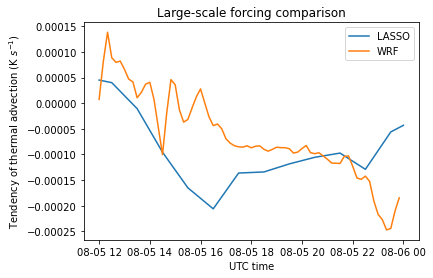

In [11]:


# cut_df = df_0805e['2018-08-05-12':'2018-08-05']

plt.plot(sel0805['Time'], sel0805['TH_ADV'][:, 5], label='LASSO')
plt.plot(mean_0805e, label='WRF')

plt.title('Large-scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

In [2]:
target_date = '2018-08-05'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'

In [24]:
xa_0805e11 = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude+0.1,site_longitude+0.1),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00

In [26]:
df_0805e11 = convert_xa_to_df(xa_0805e11, target_date)

In [25]:
xa_0805e12 = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude-0.1,site_longitude-0.1),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00

In [27]:
df_0805e12 = convert_xa_to_df(xa_0805e12, target_date)

In [52]:
xa_0805e21 = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude+0.1,site_longitude-0.1),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

df_0805e21 = convert_xa_to_df(xa_0805e21, target_date)

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00

In [53]:
xa_0805e22 = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude-0.1,site_longitude+0.1),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

df_0805e22 = convert_xa_to_df(xa_0805e22, target_date)

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_22:00:00

In [3]:
# leads to error at restart times... 
xa_0805e = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

df_0805e = convert_xa_to_df(xa_0805e, target_date)

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_00:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_01:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_02:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_03:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_04:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_05:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_06:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_07:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_08:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_09:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/mmc_d02_2018-08-05_10:00:00

In [10]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

# ds = xr.open_dataset(lasso_file, decode_cf=True, decode_times=False)
ds = xr.open_dataset(lasso_file)

for ind, val in enumerate(ds['Times']): 

    ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
    ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
#     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

ds = ds.assign_coords({'Time': ds.Times})

ds

<xarray.Dataset>
Dimensions:      (Time: 31, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
    Z_LS         (Time, force_layers) float32 ...
    U_LS         (Time, force_layers) float32 ...
    V_LS         (Time, force_layers) float32 ...
    W_LS         (Time, force_layers) float32 ...
    TH_ADV       (Time, force_layers) float32 ...
    TH_RLX       (Time, force_layers) float32 ...
    QV_ADV       (Time, force_layers) float32 ...
    QV_RLX       (Time, force_layers) float32 ...
    Z_LS_TEND    (Time, force_layers) float32 ...
    W_LS_TEND    (Time, force_layers) float32 ...
    U_LS_TEND    (Time, force_layers) float32 ...
    V_LS_TEND    (Time, force_layers) float32 ...
    TH_ADV_TEND  (Time, force_layers) float32 ...
    TH_RLX_TEND  (Time, force_layers) float32 ...
    QV_ADV_TEND  (Time, force_layers) float32 ...
    QV_RLX_TEND  (Time, force_layers) float32 ...
    INV_TAU_S    (Time, force_layers) float32 ...
    INV_TAU_M    (Time, force_layers) float32 ...
    P_SFC_OPT    (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

,height,U10,V10,U,V,W,theta,T_TEND_ADV,MUT,RU_TEND,MUU,RV_TEND,MUV,ws,wd,ws10,wd10,t_adv,u_tend,v_tend
datetime,,,,,,,,,,,,,,,,,,,,
2018-08-05 00:00:00,0.0,0.651752,7.434632,0.000000,0.000000,0.000000,308.211323,-4.380346,87146.139614,-78.249972,87132.126051,12.518003,87145.280979,0.000000,180.000000,7.463145,185.009986,-0.000050,-0.000898,0.000144
2018-08-05 00:00:00,5.0,0.651752,7.434632,0.587931,6.632307,-0.018579,310.041437,-4.059279,87146.139614,-89.354168,87132.126051,1.622297,87145.280979,6.658315,185.065826,7.463145,185.009986,-0.000047,-0.001026,0.000019
2018-08-05 00:00:00,10.0,0.651752,7.434632,0.669744,7.735750,-0.022772,309.995082,-5.564747,87146.139614,1.008463,87132.126051,-5.353422,87145.280979,7.764688,184.948205,7.463145,185.009986,-0.000064,0.000012,-0.000061
2018-08-05 00:00:00,15.0,0.651752,7.434632,0.746268,8.452737,-0.027230,309.979100,-4.389577,87146.139614,25.567279,87132.126051,-10.279934,87145.280979,8.485616,185.045400,7.463145,185.009986,-0.000050,0.000293,-0.000118
2018-08-05 00:00:00,20.0,0.651752,7.434632,0.787727,8.948769,-0.029228,309.959323,-5.095174,87146.139614,-70.117140,87132.126051,-1.938717,87145.280979,8.983372,185.030569,7.463145,185.009986,-0.000058,-0.000805,-0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-05 23:50:00,1980.0,-0.599968,6.496499,3.860966,7.409664,0.049730,312.985628,-1.246700,87201.509401,4.442679,87190.097723,45.006566,87200.323656,8.355249,207.522747,6.524145,174.723559,-0.000014,0.000051,0.000516
2018-08-05 23:50:00,1985.0,-0.599968,6.496499,3.883925,7.379840,0.049241,312.990635,-1.070559,87201.509401,4.015979,87190.097723,45.002978,87200.323656,8.339479,207.757318,6.524145,174.723559,-0.000012,0.000046,0.000516
2018-08-05 23:50:00,1990.0,-0.599968,6.496499,3.906884,7.350016,0.048752,312.995642,-0.894418,87201.509401,3.589278,87190.097723,44.999390,87200.323656,8.323850,207.992774,6.524145,174.723559,-0.000010,0.000041,0.000516


In [38]:
cut_df = df_0805e['2018-08-05-12':'2018-08-05']

cut_df.loc[cut_df['height'] == 80]['t_adv']

datetime
2018-08-05 12:00:00    0.000190
2018-08-05 12:10:00    0.000131
2018-08-05 12:20:00    0.000154
2018-08-05 12:30:00    0.000187
2018-08-05 12:40:00    0.000148
                         ...   
2018-08-05 23:10:00   -0.000101
2018-08-05 23:20:00   -0.000111
2018-08-05 23:30:00   -0.000098
2018-08-05 23:40:00   -0.000094
2018-08-05 23:50:00   -0.000049
Name: t_adv, Length: 72, dtype: float64

In [39]:
df_0805e12

df_0805e12.loc[df_0805e12['height'] == 80]['t_adv']

datetime
2018-08-05 12:00:00   -0.000002
2018-08-05 12:10:00    0.000009
2018-08-05 12:20:00   -0.000023
2018-08-05 12:30:00   -0.000024
2018-08-05 12:40:00   -0.000039
                         ...   
2018-08-05 23:10:00   -0.000201
2018-08-05 23:20:00   -0.000217
2018-08-05 23:30:00   -0.000236
2018-08-05 23:40:00   -0.000215
2018-08-05 23:50:00   -0.000199
Name: t_adv, Length: 72, dtype: float64

In [54]:
mean = (cut_df.loc[cut_df['height'] == 80]['t_adv']
        +df_0805e11.loc[df_0805e12['height'] == 80]['t_adv']
        +df_0805e12.loc[df_0805e12['height'] == 80]['t_adv']
        +df_0805e21.loc[df_0805e12['height'] == 80]['t_adv']
        +df_0805e22.loc[df_0805e12['height'] == 80]['t_adv'])/5

In [61]:
mean

datetime
2018-08-05 12:00:00    0.000007
2018-08-05 12:10:00    0.000081
2018-08-05 12:20:00    0.000138
2018-08-05 12:30:00    0.000089
2018-08-05 12:40:00    0.000080
                         ...   
2018-08-05 23:10:00   -0.000227
2018-08-05 23:20:00   -0.000247
2018-08-05 23:30:00   -0.000244
2018-08-05 23:40:00   -0.000210
2018-08-05 23:50:00   -0.000184
Name: t_adv, Length: 72, dtype: float64

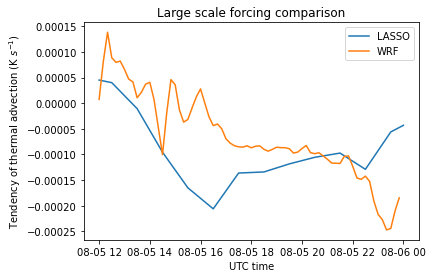

In [65]:
sel = ds.sel(Time=slice(datetime.datetime(2018, 8, 5), datetime.datetime(2018, 8, 6)))

cut_df = df_0805e['2018-08-05-12':'2018-08-05']

plt.plot(sel['Time'], sel['TH_ADV'][:, 10], label='LASSO')
plt.plot(mean, label='WRF')

plt.title('Large scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

<AxesSubplot:xlabel='datetime'>

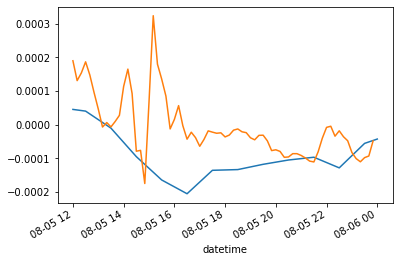

In [28]:
sel = ds.sel(Time=slice(datetime.datetime(2018, 8, 5), datetime.datetime(2018, 8, 6)))

cut_df = df_0805e['2018-08-05-12':'2018-08-05']

plt.plot(sel['Time'], sel['TH_ADV'][:, 10])
cut_df.loc[cut_df['height'] == 80]['t_adv'].plot()

<AxesSubplot:xlabel='datetime'>

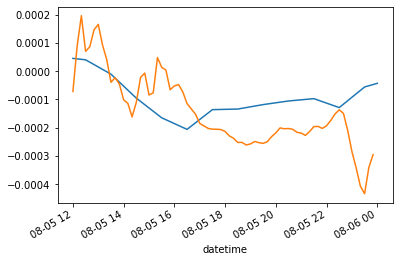

In [29]:
cut_df = df_0805e11['2018-08-05-12':'2018-08-05']

plt.plot(sel['Time'], sel['TH_ADV'][:, 10])
cut_df.loc[cut_df['height'] == 80]['t_adv'].plot()

<AxesSubplot:xlabel='datetime'>

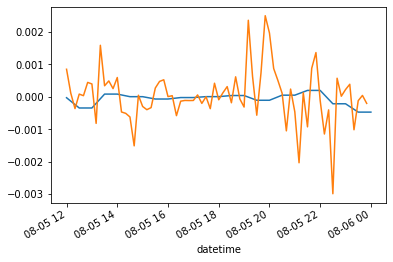

In [23]:
plt.plot(sel['Time'], sel['U_LS_TEND'][:, 10])
cut_df.loc[cut_df['height'] == 80]['u_tend'].plot()

<AxesSubplot:xlabel='datetime'>

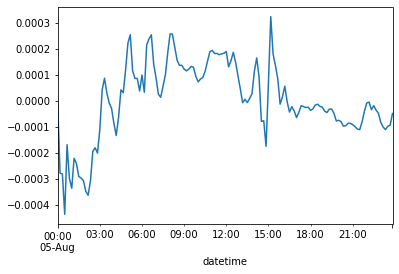

In [10]:
df = convert_xa_to_df(xa, target_date)

df.loc[df['height'] == 80]['t_adv'].plot()

<AxesSubplot:xlabel='datetime'>

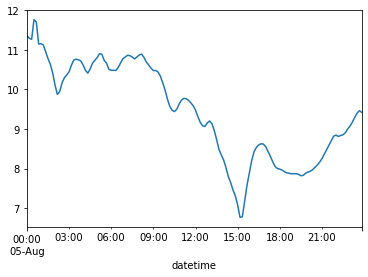

In [11]:
df.loc[df['height'] == 80]['ws'].plot()

In [14]:
dpath = '/projects/mmcpnnl/jlee/lasso/0805-3/config/'
file_filter  = 'input_ls_*'

xb = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

ERROR:root:Error while reading /projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc
Traceback (most recent call last):
  File "/home/jlee/pkgs/mmctools/mmctools/dataloaders.py", line 101, in read_dir
    df = reader(fpath,verbose=verbose,**kwargs)
  File "/home/jlee/pkgs/mmctools/mmctools/wrf/utils.py", line 798, in extract_column_from_wrfdata
  File "/home/jlee/pkgs/mmctools/mmctools/wrf/utils.py", line 725, in wrf_times_to_datetime
    return [ datetime.strptime(s.values.tostring().decode(), format) for s in timestrs ]
  File "/home/jlee/pkgs/mmctools/mmctools/wrf/utils.py", line 725, in <listcomp>
    return [ datetime.strptime(s.values.tostring().decode(), format) for s in timestrs ]
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf0 in position 0: invalid continuation byte


Reading /projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc
hiii
No dataframes were read!


In [175]:
import xarray as xr
from mmctools.wrf.utils import wrf_times_to_datetime

lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'

# ds = xr.open_dataset(lasso_file, decode_cf=True, decode_times=False)
ds = xr.open_dataset(lasso_file)

for ind, val in enumerate(ds['Times']): 

    ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
    ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
#     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

# ds = wrf_times_to_datetime(ds)

ds = ds.assign_coords({'Time': ds.Times})

# ds = xr.decode_cf(ds)

ds

<xarray.Dataset>
Dimensions:      (Time: 31, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
    Z_LS         (Time, force_layers) float32 ...
    U_LS         (Time, force_layers) float32 ...
    V_LS         (Time, force_layers) float32 ...
    W_LS         (Time, force_layers) float32 ...
    TH_ADV       (Time, force_layers) float32 ...
    TH_RLX       (Time, force_layers) float32 ...
    QV_ADV       (Time, force_layers) float32 ...
    QV_RLX       (Time, force_layers) float32 ...
    Z_LS_TEND    (Time, force_layers) float32 ...
    W_LS_TEND    (Time, force_layers) float32 ...
    U_LS_TEND    (Time, force_layers) float32 ...
    V_LS_TEND    (Time, force_layers) float32 ...
    TH_ADV_TEND  (Time, force_layers) float32 ...
    TH_RLX_TEND  (Time, force_layers) float32 ...
    QV_ADV_TEND  (Time, force_layers) float32 ...
    QV_RLX_TEND  (Time, force_layers) float32 ...
    INV_TAU_S    (Time, force_layers) float32 ...
    INV_TAU_M    (Time, force_layers) float32 ...
    P_SFC_OPT    (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

In [162]:
datetime.datetime(2011, 6, 1)

datetime.datetime(2011, 6, 1, 0, 0)

In [165]:
ds['t']

<xarray.DataArray 't' (Time: 31)>
array([datetime.datetime(2018, 8, 5, 12, 0),
       datetime.datetime(2018, 8, 5, 12, 30),
       datetime.datetime(2018, 8, 5, 13, 0),
       datetime.datetime(2018, 8, 5, 13, 30),
       datetime.datetime(2018, 8, 5, 14, 0),
       datetime.datetime(2018, 8, 5, 14, 30),
       datetime.datetime(2018, 8, 5, 15, 0),
       datetime.datetime(2018, 8, 5, 15, 30),
       datetime.datetime(2018, 8, 5, 16, 0),
       datetime.datetime(2018, 8, 5, 16, 30),
       datetime.datetime(2018, 8, 5, 17, 0),
       datetime.datetime(2018, 8, 5, 17, 30),
       datetime.datetime(2018, 8, 5, 18, 0),
       datetime.datetime(2018, 8, 5, 18, 30),
       datetime.datetime(2018, 8, 5, 19, 0),
       datetime.datetime(2018, 8, 5, 19, 30),
       datetime.datetime(2018, 8, 5, 20, 0),
       datetime.datetime(2018, 8, 5, 20, 30),
       datetime.datetime(2018, 8, 5, 21, 0),
       datetime.datetime(2018, 8, 5, 21, 30),
       datetime.datetime(2018, 8, 5, 22, 0),
       datetime.datetime(2018, 8, 5, 22, 30),
       datetime.datetime(2018, 8, 5, 23, 0),
       datetime.datetime(2018, 8, 5, 23, 30),
       datetime.datetime(2018, 8, 6, 0, 0),
       datetime.datetime(2018, 8, 6, 0, 30),
       datetime.datetime(2018, 8, 6, 1, 0),
       datetime.datetime(2018, 8, 6, 1, 30),
       datetime.datetime(2018, 8, 6, 2, 0),
       datetime.datetime(2018, 8, 6, 2, 30),
       datetime.datetime(2018, 8, 6, 3, 0)], dtype=object)
Coordinates:
    t        (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
Dimensions without coordinates: Time

In [171]:
ds['t'] > datetime.datetime(2018, 8, 5)

<xarray.DataArray 't' (Time: 31)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
    t        (Time) object 2018-08-05T12:00:00 ... 2018-08-06T03:00:00
Dimensions without coordinates: Time

In [193]:
df['2018-08-05-12':'2018-08-05']

,height,U10,V10,U,V,W,theta,T_TEND_ADV,MUT,ws,wd,ws10,wd10,t_adv
datetime,,,,,,,,,,,,,,
2018-08-05 12:00:00,0.0,-0.048699,4.726513,0.000000,0.000000,0.000000,296.170709,-3.859502,87584.228466,0.000000,180.000000,4.726764,179.409685,-0.000044
2018-08-05 12:00:00,5.0,-0.048699,4.726513,-0.057497,4.050394,-0.008879,298.731434,-4.759125,87584.228466,4.050802,179.186722,4.726764,179.409685,-0.000054
2018-08-05 12:00:00,10.0,-0.048699,4.726513,-0.039919,4.972892,-0.011586,298.846956,-4.078792,87584.228466,4.973053,179.540080,4.726764,179.409685,-0.000047
2018-08-05 12:00:00,15.0,-0.048699,4.726513,-0.017465,5.459545,-0.013246,298.924309,-2.078091,87584.228466,5.459573,179.816709,4.726764,179.409685,-0.000024
2018-08-05 12:00:00,20.0,-0.048699,4.726513,0.011894,5.915063,-0.013756,298.989780,-1.533569,87584.228466,5.915075,180.115208,4.726764,179.409685,-0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-05 23:50:00,1980.0,-0.599968,6.496499,3.860966,7.409664,0.049730,312.985628,-1.246700,87201.509401,8.355249,207.522747,6.524145,174.723559,-0.000014
2018-08-05 23:50:00,1985.0,-0.599968,6.496499,3.883925,7.379840,0.049241,312.990635,-1.070559,87201.509401,8.339479,207.757318,6.524145,174.723559,-0.000012
2018-08-05 23:50:00,1990.0,-0.599968,6.496499,3.906884,7.350016,0.048752,312.995642,-0.894418,87201.509401,8.323850,207.992774,6.524145,174.723559,-0.000010


<AxesSubplot:xlabel='datetime'>

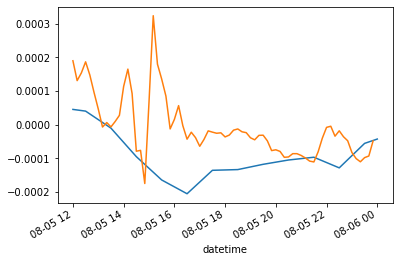

In [196]:
sel = ds.sel(Time=slice(datetime.datetime(2018, 8, 5), datetime.datetime(2018, 8, 6)))
# sel = ds.sel(t=pd.datetime(2011, 6, 6))

cut_df = df['2018-08-05-12':'2018-08-05']

plt.plot(sel['Time'], sel['TH_ADV'][:, 10])
cut_df.loc[cut_df['height'] == 80]['t_adv'].plot()

In [183]:
sel

<xarray.Dataset>
Dimensions:      (Time: 25, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-08-05T12:00:00 ... 2018-08-06
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-08-05T12:00:00 ... 2018-08-06
    Z_LS         (Time, force_layers) float32 0.0 20.0 ... 1.498e+04 1.5e+04
    U_LS         (Time, force_layers) float32 -0.07477 0.00518 ... 8.959 8.788
    V_LS         (Time, force_layers) float32 4.417 4.436 5.69 ... -3.474 -3.339
    W_LS         (Time, force_layers) float32 0.0 -0.0003022 ... -0.002127
    TH_ADV       (Time, force_layers) float32 2.934e-06 9.621e-07 ... -0.0004346
    TH_RLX       (Time, force_layers) float32 300.2 300.1 300.3 ... 373.4 373.8
    QV_ADV       (Time, force_layers) float32 1.982e-08 2.437e-08 ... -6.252e-11
    QV_RLX       (Time, force_layers) float32 0.01183 0.01171 ... 4.203e-06
    Z_LS_TEND    (Time, force_layers) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    W_LS_TEND    (Time, force_layers) float32 0.0 5.379e-08 ... 4.749e-08
    U_LS_TEND    (Time, force_layers) float32 -4.732e-05 ... -2.296e-05
    V_LS_TEND    (Time, force_layers) float32 9.158e-05 -9.885e-05 ... 5.359e-05
    TH_ADV_TEND  (Time, force_layers) float32 -9.011e-09 ... -6.878e-08
    TH_RLX_TEND  (Time, force_layers) float32 0.0003975 0.0002268 ... -0.0003529
    QV_ADV_TEND  (Time, force_layers) float32 -1.1e-11 -1.183e-11 ... -3.103e-15
    QV_RLX_TEND  (Time, force_layers) float32 1.103e-07 7.925e-08 ... -6.631e-11
    INV_TAU_S    (Time, force_layers) float32 0.0 0.0 ... 2.315e-05 2.315e-05
    INV_TAU_M    (Time, force_layers) float32 0.0 0.0 ... 9.259e-05 9.259e-05
    P_SFC_OPT    (Time) float32 979.4 979.6 979.7 979.8 ... 977.2 977.2 977.2
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

In [103]:
ds.Times.values[0]

datetime.datetime(2018, 8, 5, 12, 0)

In [101]:
datetime.datetime.strptime(ds.Times.values[0], '%Y-%m-%d_%H:%M:%S')

datetime.datetime(2018, 8, 5, 12, 0)

In [95]:
[ datetime.strptime(ds.values.tostring().decode(), '%Y-%m-%d_%H:%M:%S') for s in timestrs ]

NameError: name 'timestrs' is not defined

In [87]:
ds['Times']

<xarray.DataArray 'Times' (Time: 31)>
array(['2018-08-05_12:00:00', '2018-08-05_12:30:00', '2018-08-05_13:00:00',
       '2018-08-05_13:30:00', '2018-08-05_14:00:00', '2018-08-05_14:30:00',
       '2018-08-05_15:00:00', '2018-08-05_15:30:00', '2018-08-05_16:00:00',
       '2018-08-05_16:30:00', '2018-08-05_17:00:00', '2018-08-05_17:30:00',
       '2018-08-05_18:00:00', '2018-08-05_18:30:00', '2018-08-05_19:00:00',
       '2018-08-05_19:30:00', '2018-08-05_20:00:00', '2018-08-05_20:30:00',
       '2018-08-05_21:00:00', '2018-08-05_21:30:00', '2018-08-05_22:00:00',
       '2018-08-05_22:30:00', '2018-08-05_23:00:00', '2018-08-05_23:30:00',
       '2018-08-06_00:00:00', '2018-08-06_00:30:00', '2018-08-06_01:00:00',
       '2018-08-06_01:30:00', '2018-08-06_02:00:00', '2018-08-06_02:30:00',
       '2018-08-06_03:00:00'], dtype=object)
Dimensions without coordinates: Time

In [77]:
import datetime

type(ds.Times[0].values)

ds.Times.values[0].decode("utf-8") 

# datetime.datetime(int(float(ds.Times[0])))

'2018-08-05_12:00:00'

In [57]:
eval(ds.Times.values[0])

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)

In [65]:
ds.Times.values[0]

b'2018-08-05_12:00:00'

In [33]:
pd.to_datetime(ds.Times)

TypeError: <class 'bytes'> is not convertible to datetime

In [19]:
ds['Times']

<xarray.DataArray 'Times' (Time: 31)>
array([b'2018-08-05_12:00:00', b'2018-08-05_12:30:00', b'2018-08-05_13:00:00',
       b'2018-08-05_13:30:00', b'2018-08-05_14:00:00', b'2018-08-05_14:30:00',
       b'2018-08-05_15:00:00', b'2018-08-05_15:30:00', b'2018-08-05_16:00:00',
       b'2018-08-05_16:30:00', b'2018-08-05_17:00:00', b'2018-08-05_17:30:00',
       b'2018-08-05_18:00:00', b'2018-08-05_18:30:00', b'2018-08-05_19:00:00',
       b'2018-08-05_19:30:00', b'2018-08-05_20:00:00', b'2018-08-05_20:30:00',
       b'2018-08-05_21:00:00', b'2018-08-05_21:30:00', b'2018-08-05_22:00:00',
       b'2018-08-05_22:30:00', b'2018-08-05_23:00:00', b'2018-08-05_23:30:00',
       b'2018-08-06_00:00:00', b'2018-08-06_00:30:00', b'2018-08-06_01:00:00',
       b'2018-08-06_01:30:00', b'2018-08-06_02:00:00', b'2018-08-06_02:30:00',
       b'2018-08-06_03:00:00'], dtype=object)
Dimensions without coordinates: Time

In [18]:
ds['TH_ADV']

<xarray.DataArray 'TH_ADV' (Time: 31, force_layers: 751)>
array([[ 2.934008e-06,  9.621326e-07, -5.463238e-06, ..., -1.206740e-05,
        -7.204985e-06, -2.342566e-06],
       [-1.328612e-05, -1.297416e-05, -1.617391e-05, ...,  1.717690e-05,
         1.828721e-05,  1.939753e-05],
       [-2.924198e-05, -3.042054e-05, -3.353919e-05, ..., -9.512689e-06,
        -1.007294e-05, -1.063319e-05],
       ...,
       [-1.770638e-05, -2.589334e-05, -4.370553e-05, ..., -4.148327e-04,
        -4.035098e-04, -3.921868e-04],
       [-2.153632e-06, -1.360725e-05, -4.090598e-05, ..., -4.732450e-04,
        -4.611958e-04, -4.491466e-04],
       [-2.597251e-05, -3.922844e-05, -6.724893e-05, ..., -3.961532e-04,
        -3.846635e-04, -3.731739e-04]], dtype=float32)
Dimensions without coordinates: Time, force_layers
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  tendency of thermal adv
    units:        K s-1
    stagger:

In [22]:
import xarray as xr
from mmctools.wrf.utils import wrf_times_to_datetime

In [29]:
import site; site.getsitepackages()

['/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages']

In [40]:
%load_ext autoreload
%autoreload 2

dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/'

ds = xr.open_dataset(dpath+'mmc_d02_2018-08-04_14:00:00', decode_times=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
ds

<xarray.Dataset>
Dimensions:       (Time: 6, bottom_top: 87, bottom_top_stag: 88, south_north: 220, south_north_stag: 221, west_east: 220, west_east_stag: 221)
Coordinates:
    XLAT          (Time, south_north, west_east) float32 ...
    XLONG         (Time, south_north, west_east) float32 ...
    XTIME         (Time) float32 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times         (Time) |S19 ...
    RU_TEND_ADV   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_PGF   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_COR   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_PHYS  (Time, bottom_top, south_north, west_east_stag) float32 ...
    RV_TEND_ADV   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_PGF   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_COR   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_PHYS  (Time, bottom_top, south_north_stag, west_east) float32 ...
    T_TEND_ADV    (Time, bottom_top, south_north, west_east) float32 ...
    U             (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND       (Time, bottom_top, south_north, west_east_stag) float32 ...
    V             (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND       (Time, bottom_top, south_north_stag, west_east) float32 ...
    W             (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH            (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB           (Time, bottom_top_stag, south_north, west_east) float32 ...
    T             (Time, bottom_top, south_north, west_east) float32 ...
    MUU           (Time, south_north, west_east_stag) float32 ...
    MUV           (Time, south_north_stag, west_east) float32 ...
    MUT           (Time, south_north, west_east) float32 ...
    P             (Time, bottom_top, south_north, west_east) float32 ...
    PB            (Time, bottom_top, south_north, west_east) float32 ...
    T2            (Time, south_north, west_east) float32 ...
    PSFC          (Time, south_north, west_east) float32 ...
    U10           (Time, south_north, west_east) float32 ...
    V10           (Time, south_north, west_east) float32 ...
    HGT           (Time, south_north, west_east) float32 ...
    TSK           (Time, south_north, west_east) float32 ...
    UST           (Time, south_north, west_east) float32 ...
    HFX           (Time, south_north, west_east) float32 ...
    LH            (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-08-04_12:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      221
    BOTTOM-TOP_GRID_DIMENSION:       88
    DX:                              3000.0
    DY:                              3000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      10
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               5
    SF_SURFACE_PHYSICS:              2
    BL_PBL_PHYSICS:                  5
    CU_PHYSICS:                      1
    SF_LAKE_PHYSICS:         

In [42]:
ds['XTIME'] = wrf_times_to_datetime(ds)

In [43]:
ds

<xarray.Dataset>
Dimensions:       (Time: 6, XTIME: 6, bottom_top: 87, bottom_top_stag: 88, south_north: 220, south_north_stag: 221, west_east: 220, west_east_stag: 221)
Coordinates:
    XLAT          (Time, south_north, west_east) float32 ...
    XLONG         (Time, south_north, west_east) float32 ...
  * XTIME         (XTIME) datetime64[ns] 2018-08-04T14:00:00 ... 2018-08-04T1...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times         (Time) |S19 b'2018-08-04_14:00:00' ... b'2018-08-04_14:50:00'
    RU_TEND_ADV   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_PGF   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_COR   (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND_PHYS  (Time, bottom_top, south_north, west_east_stag) float32 ...
    RV_TEND_ADV   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_PGF   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_COR   (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND_PHYS  (Time, bottom_top, south_north_stag, west_east) float32 ...
    T_TEND_ADV    (Time, bottom_top, south_north, west_east) float32 ...
    U             (Time, bottom_top, south_north, west_east_stag) float32 ...
    RU_TEND       (Time, bottom_top, south_north, west_east_stag) float32 ...
    V             (Time, bottom_top, south_north_stag, west_east) float32 ...
    RV_TEND       (Time, bottom_top, south_north_stag, west_east) float32 ...
    W             (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH            (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB           (Time, bottom_top_stag, south_north, west_east) float32 ...
    T             (Time, bottom_top, south_north, west_east) float32 ...
    MUU           (Time, south_north, west_east_stag) float32 ...
    MUV           (Time, south_north_stag, west_east) float32 ...
    MUT           (Time, south_north, west_east) float32 ...
    P             (Time, bottom_top, south_north, west_east) float32 ...
    PB            (Time, bottom_top, south_north, west_east) float32 ...
    T2            (Time, south_north, west_east) float32 ...
    PSFC          (Time, south_north, west_east) float32 ...
    U10           (Time, south_north, west_east) float32 ...
    V10           (Time, south_north, west_east) float32 ...
    HGT           (Time, south_north, west_east) float32 ...
    TSK           (Time, south_north, west_east) float32 ...
    UST           (Time, south_north, west_east) float32 ...
    HFX           (Time, south_north, west_east) float32 ...
    LH            (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2018-08-04_12:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      221
    BOTTOM-TOP_GRID_DIMENSION:       88
    DX:                              3000.0
    DY:                              3000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      10
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               5
    SF_SURFACE_PHYSICS:              2
    BL_

In [47]:
%load_ext autoreload
%autoreload 2

# %%time
# leads to error at restart times... 
xa = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/mmc_d02_2018-08-05_00:00:00
hiii
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/mmc_d02_2018-08-05_01:00:00
hiii


In [48]:
xa

<xarray.Dataset>
Dimensions:       (Time: 12, height: 401)
Coordinates:
  * Time          (Time) datetime64[ns] 2018-08-05 ... 2018-08-05T01:50:00
  * height        (height) float64 0.0 5.0 10.0 ... 1.99e+03 1.995e+03 2e+03
Data variables:
    U10           (Time) float64 0.6518 -0.06171 -0.6561 ... -0.8008 -0.7706
    V10           (Time) float64 7.435 7.437 7.282 7.4 ... 5.82 5.555 5.303
    T2            (Time) float64 307.9 307.6 307.3 306.9 ... 304.6 304.2 303.8
    TSK           (Time) float64 308.2 307.7 307.2 306.7 ... 303.2 302.8 302.4
    UST           (Time) float64 0.7483 0.7282 0.6989 ... 0.5037 0.4731 0.4429
    PSFC          (Time) float64 9.754e+04 9.754e+04 ... 9.76e+04 9.761e+04
    HFX           (Time) float64 21.28 5.421 -5.737 ... -60.14 -57.83 -54.88
    LH            (Time) float64 78.07 70.81 64.28 57.93 ... 6.879 6.53 6.198
    MUU           (Time) float64 8.713e+04 8.714e+04 ... 8.725e+04 8.727e+04
    MUV           (Time) float64 8.715e+04 8.715e+04 ... 8.727e+04 8.728e+04
    MUT           (Time) float64 8.715e+04 8.715e+04 ... 8.727e+04 8.728e+04
    U             (Time, height) float64 0.0 0.5879 0.6697 ... 5.57 5.602 5.633
    V             (Time, height) float64 0.0 6.632 7.736 ... 7.861 7.831 7.8
    W             (Time, height) float64 0.0 -0.01858 ... -0.03419 -0.03347
    theta         (Time, height) float64 308.2 310.0 310.0 ... 311.2 311.2 311.3
    RU_TEND       (Time, height) float64 -78.25 -89.35 1.008 ... 41.93 42.7
    RU_TEND_ADV   (Time, height) float64 -29.96 -34.78 -53.12 ... 64.62 65.63
    RU_TEND_PGF   (Time, height) float64 -96.87 -104.9 -0.8561 ... -81.38 -81.38
    RU_TEND_COR   (Time, height) float64 44.82 49.57 57.8 ... 58.48 58.25 58.02
    RU_TEND_PHYS  (Time, height) float64 3.756 0.7106 -2.814 ... 0.4404 0.4308
    RV_TEND       (Time, height) float64 12.52 1.622 -5.353 ... -16.48 -16.95
    RV_TEND_ADV   (Time, height) float64 59.73 75.82 74.86 ... -10.88 -11.09
    RV_TEND_PGF   (Time, height) float64 87.83 79.2 72.55 ... 36.13 36.11 36.09
    RV_TEND_COR   (Time, height) float64 -3.754 -4.278 -4.881 ... -41.63 -41.87
    RV_TEND_PHYS  (Time, height) float64 -131.3 -149.1 ... -0.07735 -0.07989
    T_TEND_ADV    (Time, height) float64 -4.38 -4.059 -5.565 ... 11.57 12.13

In [38]:
xa

<xarray.Dataset>
Dimensions:       (Time: 12, height: 401)
Coordinates:
  * Time          (Time) float64 120.0 130.0 140.0 150.0 ... 210.0 220.0 230.0
  * height        (height) float64 0.0 5.0 10.0 ... 1.99e+03 1.995e+03 2e+03
Data variables:
    U10           (Time) float64 0.2155 0.3136 0.3453 ... 1.236 1.453 1.552
    V10           (Time) float64 6.165 6.235 6.297 6.424 ... 7.274 7.538 7.618
    T2            (Time) float64 300.5 300.8 301.2 301.5 ... 303.6 303.9 304.3
    TSK           (Time) float64 302.4 303.1 303.7 304.2 ... 307.4 308.0 308.4
    UST           (Time) float64 0.6543 0.6692 0.6819 ... 0.7979 0.8222 0.8326
    PSFC          (Time) float64 9.784e+04 9.784e+04 ... 9.777e+04 9.776e+04
    HFX           (Time) float64 111.3 129.3 145.5 161.8 ... 254.8 272.8 276.8
    LH            (Time) float64 90.69 90.34 95.02 101.5 ... 134.2 139.7 142.2
    MUU           (Time) float64 8.746e+04 8.747e+04 ... 8.74e+04 8.739e+04
    MUV           (Time) float64 8.748e+04 8.748e+04 ... 8.741e+04 8.74e+04
    MUT           (Time) float64 8.748e+04 8.748e+04 ... 8.741e+04 8.74e+04
    U             (Time, height) float64 0.0 0.1918 0.2316 ... 7.69 7.686 7.683
    V             (Time, height) float64 0.0 5.589 6.408 ... 6.917 6.927 6.937
    W             (Time, height) float64 0.0 -0.01407 ... 0.01231 0.01285
    theta         (Time, height) float64 302.4 302.2 302.0 ... 310.4 310.4 310.5
    RU_TEND       (Time, height) float64 -31.5 36.68 36.48 ... 13.72 14.35 14.97
    RU_TEND_ADV   (Time, height) float64 9.089 12.05 11.48 ... 11.58 11.98 12.37
    RU_TEND_PGF   (Time, height) float64 -159.9 -96.17 -99.64 ... -49.19 -49.03
    RU_TEND_COR   (Time, height) float64 38.53 42.47 48.8 ... 51.5 51.57 51.63
    RU_TEND_PHYS  (Time, height) float64 80.77 78.34 ... -0.009151 -0.008403
    RV_TEND       (Time, height) float64 -225.6 -68.83 76.74 ... -3.483 -3.993
    RV_TEND_ADV   (Time, height) float64 36.84 39.74 20.18 ... 28.95 28.82 28.69
    RV_TEND_PGF   (Time, height) float64 -185.5 -30.56 114.8 ... 24.98 24.57
    RV_TEND_COR   (Time, height) float64 -1.097 -1.244 -1.524 ... -57.29 -57.26
    RV_TEND_PHYS  (Time, height) float64 -75.78 -76.77 ... 0.00944 0.009372
    T_TEND_ADV    (Time, height) float64 5.479 5.057 3.414 ... 5.53 5.515 5.501

<AxesSubplot:xlabel='datetime'>

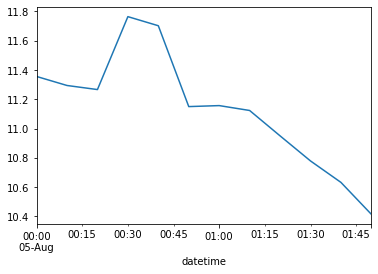

In [49]:
target_date = '2018-08-05'
df = convert_xa_to_df(xa, target_date)

df.loc[df['height'] == 80]['ws'].plot()

In [39]:
xa['Time'] = wrf_times_to_datetime(xa)

KeyError: 'Times'

In [14]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/'

ds = xr.open_dataset(dpath+'wrfout_d02_2018-08-05_12:00:00', decode_times=True)

In [15]:
ds

<xarray.Dataset>
Dimensions:                (Time: 1, bottom_top: 87, bottom_top_stag: 88, seed_dim_stag: 33, soil_layers_stag: 4, south_north: 220, south_north_stag: 221, west_east: 220, west_east_stag: 221)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, seed_dim_stag, soil_layers_stag, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times                  (Time) |S19 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    VAR_SSO                (Time, south_north, west_east) float32 ...
    RU_TEND_PGF            (Time, bottom_top, south_north, west_east_stag) float32 ...
    RV_TEND_PGF            (Time, bottom_top, south_north_stag, west_east) float32 ...
    U                      (Time, bottom_top, south_north, west_east_stag) float32 ...
    V                      (Time, bottom_top, south_north_stag, west_east) float32 ...
    W                      (Time, bottom_top_stag, south_north, west_east) float32 ...
    PH                     (Time, bottom_top_stag, south_north, west_east) float32 ...
    PHB                    (Time, bottom_top_stag, south_north, west_east) float32 ...
    T                      (Time, bottom_top, south_north, west_east) float32 ...
    THM                    (Time, bottom_top, south_north, west_east) float32 ...
    HFX_FORCE              (Time) float32 ...
    LH_FORCE               (Time) float32 ...
    TSK_FORCE              (Time) float32 ...
    HFX_FORCE_TEND         (Time) float32 ...
    LH_FORCE_TEND          (Time) float32 ...
    TSK_FORCE_TEND         (Time) float32 ...
    MUU                    (Time, south_north, west_east_stag) float32 ...
    MUV                    (Time, south_north_stag, west_east) float32 ...
    P                      (Time, bottom_top, south_north, west_east) float32 ...
    PB                     (Time, bottom_top, south_north, west_east) float32 ...
    FNM                    (Time, bottom_top) float32 ...
    FNP                    (Time, bottom_top) float32 ...
    RDNW                   (Time, bottom_top) float32 ...
    RDN                    (Time, bottom_top) float32 ...
    DNW                    (Time, bottom_top) float32 ...
    DN                     (Time, bottom_top) float32 ...
    CFN                    (Time) float32 ...
    CFN1                   (Time) float32 ...
    THIS_IS_AN_IDEAL_RUN   (Time) int32 ...
    Q2                     (Time, south_north, west_east) float32 ...
    T2                     (Time, south_north, west_east) float32 ...
    TH2                    (Time, south_north, west_east) float32 ...
    PSFC                   (Time, south_north, west_east) float32 ...
    U10                    (Time, south_north, west_east) float32 ...
    V10                    (Time, south_north, west_east) float32 ...
    RDX                    (Time) float32 ...
    RDY                    (Time) float32 ...
    AREA2D                 (Time, south_north, west_east) float32 ...
    DX2D                   (Time, south_north, west_east) float32 ...
    RESM                   (Time) float32 ...
    ZETATOP                (Time) float32 ...
    CF1                    (Time) float32 ...
    CF2                    (Time) float32 ...
    CF3                    (Time) float32 ...
    ITIMESTEP        

In [100]:
target_date = '2018-08-05'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good'

# leads to error at restart times... 
xa = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/mmc_d02_2018-08-04_14:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _de

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/mmc_d02_2018-08-04_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/good/mmc_d02_2018-08-04_15:00:00
No dataframes were read!


## 0901 mynn

In [ ]:
target_date = '2018-09-01'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/target/'

# leads to error at restart times... 
xa_0901m = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

df_0901m = convert_xa_to_df(xa_0901m, target_date)

In [95]:
target_date = '2018-09-01'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout'

%%time
# leads to error at restart times... 
xa = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_12:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_14:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_16:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_18:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_19:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_19:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_21:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_21:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_22:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_23:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-08-31_23:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_01:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_00:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_01:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_02:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_03:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_03:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_05:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_07:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_09:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_04:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_05:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_06:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_07:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_08:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_09:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_10:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_11:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_13:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_11:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_14:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_14:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_16:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_18:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_20:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_21:00:00


ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_21:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_23:00:00
Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 649, in parse
    raise ParserError("Unknown string format: %s", timestr)
dateutil.parser._parser.ParserError: Unknown string format: 0000-00-00 **:00:00

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/xarray/coding/times.py", line 148, in _decode_

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_22:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-01_23:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/mmc_d02_2018-09-02_00:00:00
No dataframes were read!
CPU times: user 330 ms, sys: 472 ms, total: 802 ms
Wall time: 2.02 s


In [83]:
xa

<xarray.Dataset>
Dimensions:      (Time: 37, height: 401)
Coordinates:
  * Time         (Time) datetime64[ns] 2018-08-31T12:00:00 ... 2018-09-02
  * height       (height) float64 0.0 5.0 10.0 15.0 ... 1.99e+03 1.995e+03 2e+03
Data variables:
    U10          (Time) float64 0.03175 -0.2937 1.031 ... -3.357 -2.949 -3.488
    V10          (Time) float64 5.937 5.866 7.297 7.624 ... 5.729 5.404 5.452
    T2           (Time) float64 297.7 298.3 300.7 303.0 ... 308.6 307.7 306.0
    TSK          (Time) float64 297.2 298.3 301.6 304.8 ... 310.2 307.9 305.3
    UST          (Time) float64 0.0001 0.5318 0.6992 ... 0.6941 0.5892 0.5588
    PSFC         (Time) float64 9.77e+04 9.767e+04 ... 9.733e+04 9.731e+04
    HFX          (Time) float64 0.0 0.5901 57.41 114.4 ... 94.07 12.0 -38.31
    LH           (Time) float64 0.0 65.79 126.8 171.8 ... 171.0 121.9 76.31
    MUU          (Time) float64 0.0 8.729e+04 8.73e+04 ... 8.7e+04 8.697e+04
    MUV          (Time) float64 0.0 8.731e+04 8.732e+04 ... 8.701e+04 8.698e+04
    U            (Time, height) float64 0.0 0.02622 0.05229 ... -1.029 -1.034
    V            (Time, height) float64 0.0 6.005 6.036 ... 6.821 6.802 6.783
    W            (Time, height) float64 0.0 -0.01279 ... 0.005079 0.006018
    theta        (Time, height) float64 297.2 299.8 299.8 ... 312.0 312.0 312.1
    RU_TEND_PGF  (Time, height) float64 0.0 0.0 0.0 0.0 ... -86.0 -84.09 -82.19
    RV_TEND_PGF  (Time, height) float64 0.0 0.0 0.0 0.0 ... 23.03 22.23 21.44

<AxesSubplot:xlabel='datetime'>

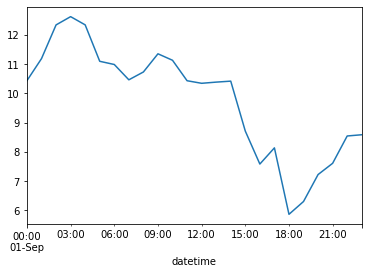

In [89]:
df = convert_xa_to_df(xa, target_date)

df.loc[df['height'] == 80]['ws'].plot()

In [54]:
df.columns

Index(['height', 'U10', 'V10', 'U', 'V', 'W', 'theta', 'T_TEND_ADV', 'ws',
       'wd', 'ws10', 'wd10'],
      dtype='object')

In [ ]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/'

In [3]:
%%time
# leads to error at restart times... 
xa = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-08-31_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_04:00:00
Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 655, in parse
    ret = self._build_naive(res, default)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1241, in _build_naive
    naive = default.replace(**repl)
ValueError: year 0 is out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_04:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_05:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_06:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_07:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_08:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_09:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_10:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_11:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_20:00:00
Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 655, in parse
    ret = self._build_naive(res, default)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1241, in _build_naive
    naive = default.replace(**repl)
ValueError: year 0 is out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_22:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-01_23:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_mynn/auxout/mmc_d02_2018-09-02_00:00:00
CPU times: user 2min 29s, sys: 1min 45s, total: 4min 15s
Wall time: 9min 3s


In [73]:
xa.to_dataframe().head()

U10       V10          T2         TSK  \
Time                height                                               
2018-08-31 12:00:00 0.0     0.031754  5.936772  297.678113  297.152345   
                    5.0     0.031754  5.936772  297.678113  297.152345   
                    10.0    0.031754  5.936772  297.678113  297.152345   
                    15.0    0.031754  5.936772  297.678113  297.152345   
                    20.0    0.031754  5.936772  297.678113  297.152345   

                               UST         PSFC  HFX   LH  MUU  MUV  ...  \
Time                height                                           ...   
2018-08-31 12:00:00 0.0     0.0001  97696.64127  0.0  0.0  0.0  0.0  ...   
                    5.0     0.0001  97696.64127  0.0  0.0  0.0  0.0  ...   
                    10.0    0.0001  97696.64127  0.0  0.0  0.0  0.0  ...   
                    15.0    0.0001  97696.64127  0.0  0.0  0.0  0.0  ...   
                    20.0    0.0001  97696.64127  0.0  0.0  0.0  0.0  ...   

                            RU_TEND_ADV  RU_TEND_PGF  RU_TEND_COR  \
Time                height                                          
2018-08-31 12:00:00 0.0             0.0          0.0          0.0   
                    5.0             0.0          0.0          0.0   
                    10.0            0.0          0.0          0.0   
                    15.0            0.0          0.0          0.0   
                    20.0            0.0          0.0          0.0   

                            RU_TEND_PHYS  RV_TEND  RV_TEND_ADV  RV_TEND_PGF  \
Time                height                                                    
2018-08-31 12:00:00 0.0              0.0      0.0          0.0          0.0   
                    5.0              0.0      0.0          0.0          0.0   
                    10.0             0.0      0.0          0.0          0.0   
                    15.0             0.0      0.0          0.0          0.0   
                    20.0             0.0      0.0          0.0          0.0   

                            RV_TEND_COR  RV_TEND_PHYS  T_TEND_ADV  
Time                height                                         
2018-08-31 12:00:00 0.0             0.0           0.0         0.0  
                    5.0             0.0           0.0         0.0  
                    10.0            0.0           0.0         0.0  
                    15.0            0.0           0.0         0.0  
                    20.0            0.0           0.0         0.0  

[5 rows x 26 columns]

In [40]:
df = convert_xa_to_df(xa, target_date)

<AxesSubplot:xlabel='datetime'>

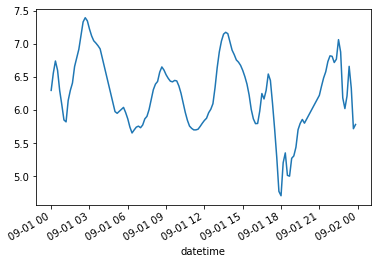

In [23]:
df.loc[df['height'] == 10]['ws10'].plot()

<AxesSubplot:xlabel='datetime'>

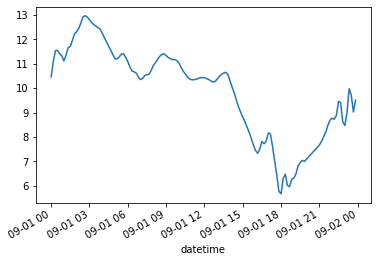

In [24]:
df.loc[df['height'] == 80]['ws'].plot()

<AxesSubplot:xlabel='datetime'>

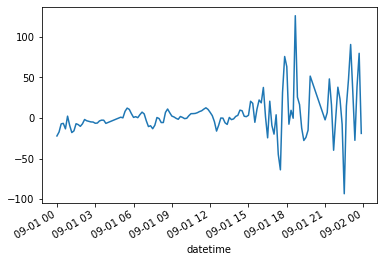

In [7]:
df.loc[df['height'] == 80]['T_TEND_ADV'].plot()

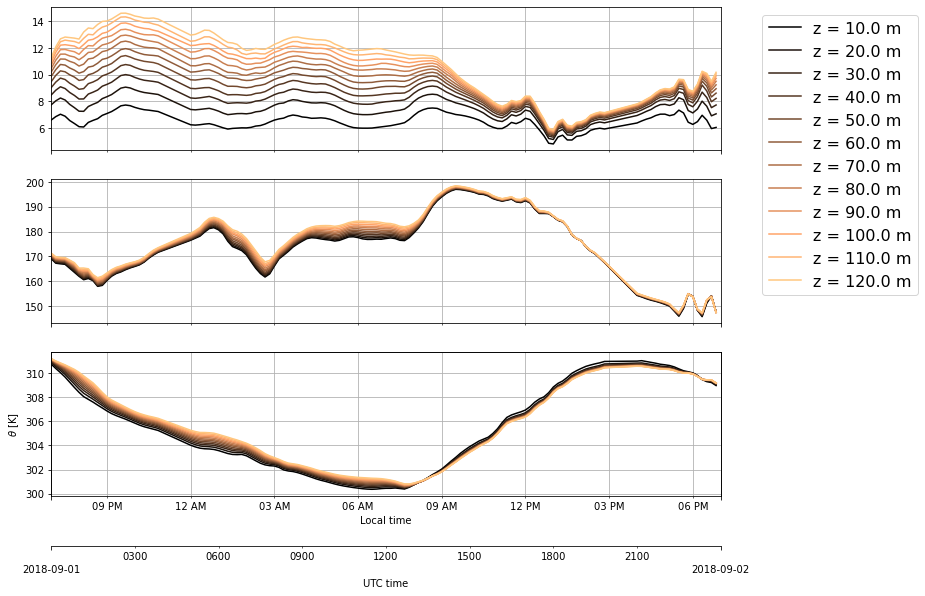

In [35]:
fig, ax, ax2 = plot_timehistory_at_height(
    df,
    fields=['ws', 'wd', 'theta'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2018-09-01 00:00', '2018-09-02 00:00'],
#     fieldlimits={'ws':(4,15), 'wd':(180,240)},
    plot_local_time=True,
    local_time_offset=-5
)

# plt.savefig('plots/02/ws_ts.pdf')

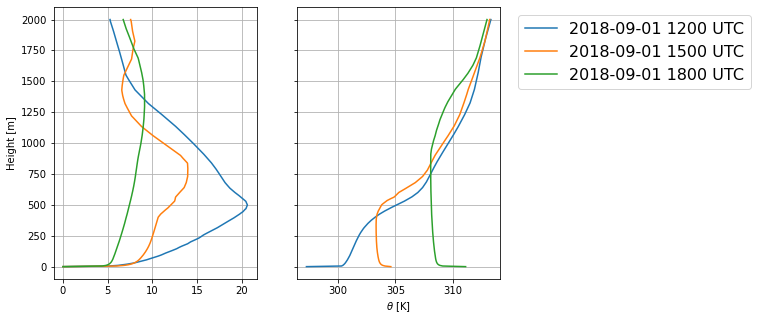

In [33]:
fig,ax = plot_profile(
    df,
    fields=['ws', 'theta'],
    times=['2018-09-01 12:00', '2018-09-01 15:00', '2018-09-01 18:00'],
    fieldlabels={'theta':r'$\theta$ [K]'},
    showlegend=True
)

## 0901 edmf

In [6]:
target_date = '2018-09-01'
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/'

df_0901e = get_df(target_date, dpath, 0, 0)
df_0901e2 = get_df(target_date, dpath, 0.1, 0.1)
df_0901e3 = get_df(target_date, dpath, 0.1, -0.1)
df_0901e4 = get_df(target_date, dpath, -0.1, 0.1)
df_0901e5 = get_df(target_date, dpath, -0.1, -0.1)

mean_0901e = (df_0901e.loc[df_0901e['height'] == 80]['t_adv']
              +df_0901e2.loc[df_0901e2['height'] == 80]['t_adv']
              +df_0901e3.loc[df_0901e3['height'] == 80]['t_adv']
              +df_0901e4.loc[df_0901e4['height'] == 80]['t_adv']
              +df_0901e5.loc[df_0901e5['height'] == 80]['t_adv'])/5

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/mmc_d02_2018-09-01_22:00:00

In [7]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0901-3/config/input_ls_forcing.nc'

# ds = xr.open_dataset(lasso_file, decode_cf=True, decode_times=False)
ds = xr.open_dataset(lasso_file)

for ind, val in enumerate(ds['Times']): 

    ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
    ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
#     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

ds0901 = ds.assign_coords({'Time': ds.Times})

ds0901

<xarray.Dataset>
Dimensions:      (Time: 31, force_layers: 751)
Coordinates:
  * Time         (Time) object 2018-09-01T12:00:00 ... 2018-09-02T03:00:00
Dimensions without coordinates: force_layers
Data variables:
    Times        (Time) object 2018-09-01T12:00:00 ... 2018-09-02T03:00:00
    Z_LS         (Time, force_layers) float32 ...
    U_LS         (Time, force_layers) float32 ...
    V_LS         (Time, force_layers) float32 ...
    W_LS         (Time, force_layers) float32 ...
    TH_ADV       (Time, force_layers) float32 ...
    TH_RLX       (Time, force_layers) float32 ...
    QV_ADV       (Time, force_layers) float32 ...
    QV_RLX       (Time, force_layers) float32 ...
    Z_LS_TEND    (Time, force_layers) float32 ...
    W_LS_TEND    (Time, force_layers) float32 ...
    U_LS_TEND    (Time, force_layers) float32 ...
    V_LS_TEND    (Time, force_layers) float32 ...
    TH_ADV_TEND  (Time, force_layers) float32 ...
    TH_RLX_TEND  (Time, force_layers) float32 ...
    QV_ADV_TEND  (Time, force_layers) float32 ...
    QV_RLX_TEND  (Time, force_layers) float32 ...
    INV_TAU_S    (Time, force_layers) float32 ...
    INV_TAU_M    (Time, force_layers) float32 ...
    P_SFC_OPT    (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180901.nc

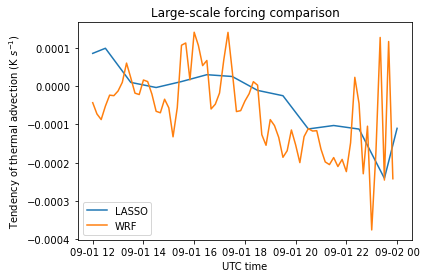

In [10]:
sel0901 = ds0901.sel(Time=slice(datetime.datetime(2018, 9, 1), datetime.datetime(2018, 9, 2)))

# cut_df = df_0805e['2018-08-05-12':'2018-08-05']

plt.plot(sel0901['Time'], sel0901['TH_ADV'][:, 10], label='LASSO')
plt.plot(mean_0901e, label='WRF')

plt.title('Large-scale forcing comparison')
plt.xlabel('UTC time')
plt.ylabel(r'Tendency of thermal advection (K $s^{-1}$)')
plt.legend()
plt.show()

In [45]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/'

In [46]:
%%time
# leads to error at restart times... 
xa_0901e = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-08-31_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mm

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_18:00:00
Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 655, in parse
    ret = self._build_naive(res, default)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1241, in _build_naive
    naive = default.replace(**repl)
ValueError: year 0 is out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **k

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_22:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-01_23:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/analysis/0901e/auxout/mmc_d02_2018-09-02_00:00:00
CPU times: user 2min 38s, sys: 3min 16s, total: 5min 54s
Wall time: 9min 4s


In [47]:
df_0901e = convert_xa_to_df(xa_0901e, target_date)

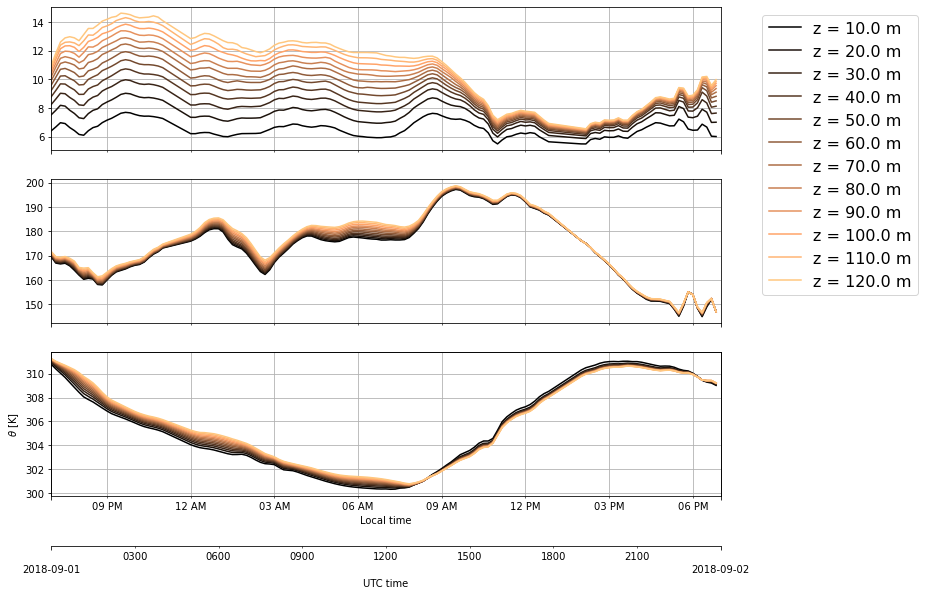

In [48]:
fig, ax, ax2 = plot_timehistory_at_height(
    df_0901e,
    fields=['ws', 'wd', 'theta'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2018-09-01 00:00', '2018-09-02 00:00'],
#     fieldlimits={'ws':(4,15), 'wd':(180,240)},
    plot_local_time=True,
    local_time_offset=-5
)

In [37]:
dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/'

In [38]:
%%time
# leads to error at restart times... 
xa_0901e = read_dir(dpath, file_filter=file_filter, 
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter, L_filter=L_filter
             )

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_13:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_14:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_15:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_16:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_17:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_18:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-08-31_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_04:00:00
Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 655, in parse
    ret = self._build_naive(res, default)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1241, in _build_naive
    naive = default.replace(**repl)
ValueError: year 0 is out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_04:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_05:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_06:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_07:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_08:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_09:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_10:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_11:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_12:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_

ERROR:root:Error while reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_18:00:00
Traceback (most recent call last):
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 655, in parse
    ret = self._build_naive(res, default)
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1241, in _build_naive
    naive = default.replace(**repl)
ValueError: year 0 is out of range

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas/_libs/tslibs/conversion.pyx", line 639, in pandas._libs.tslibs.conversion._convert_str_to_tsobject
  File "pandas/_libs/tslibs/parsing.pyx", line 243, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/dateutil/parser/_parser.py", line 1374, in parse
    return DEFAULTPARSER.parse(timestr, **kwargs

Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_19:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_20:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_21:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_22:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-01_23:00:00
Reading /projects/mmcpnnl/jlee/wrf-mmc/sgp/sgp_mynn_edmf/0901_edmf/auxout/mmc_d02_2018-09-02_00:00:00
CPU times: user 2min 28s, sys: 1min 44s, total: 4min 13s
Wall time: 9min 13s


In [41]:
df_0901e = convert_xa_to_df(xa_0901e, target_date)

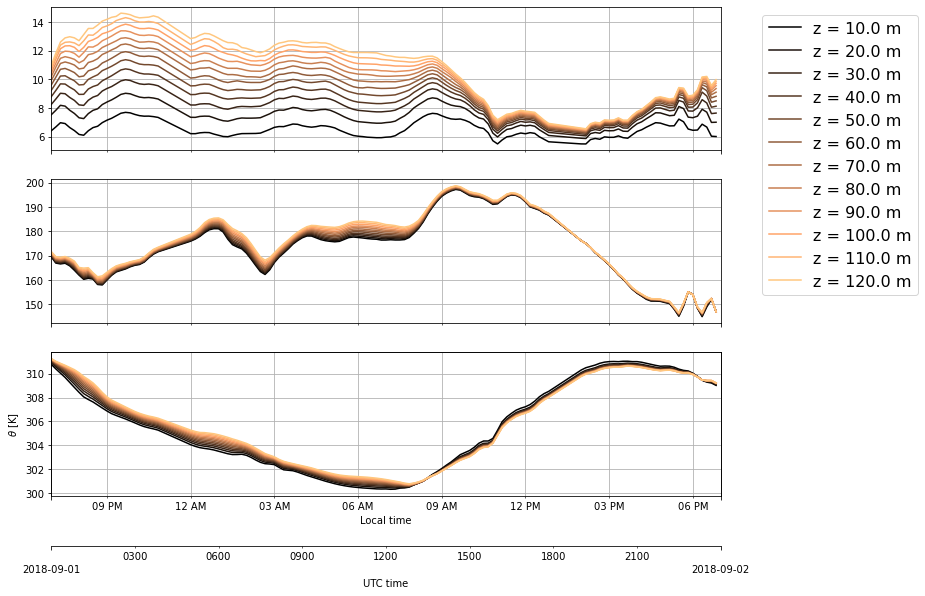

In [42]:
fig, ax, ax2 = plot_timehistory_at_height(
    df_0901e,
    fields=['ws', 'wd', 'theta'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2018-09-01 00:00', '2018-09-02 00:00'],
#     fieldlimits={'ws':(4,15), 'wd':(180,240)},
    plot_local_time=True,
    local_time_offset=-5
)

x and y must have same first dimension, but have shapes (0, 401) and (401,) -- 2018-09-01 18:00 not found in index?
x and y must have same first dimension, but have shapes (0, 401) and (401,) -- 2018-09-01 18:00 not found in index?


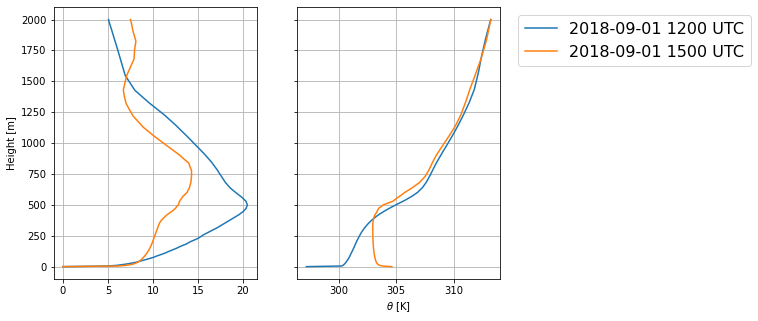

In [43]:
fig,ax = plot_profile(
    df_0901e,
    fields=['ws', 'theta'],
    times=['2018-09-01 12:00', '2018-09-01 15:00', '2018-09-01 18:00'],
    fieldlabels={'theta':r'$\theta$ [K]'},
    showlegend=True
)